### ANIME Face generator ###

In [1]:
#important imports and metrics used
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Reshape, Dense 
from tensorflow.keras.layers import Flatten, BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import LeakyReLU , ReLU
from tensorflow.keras.layers import Conv2D ,Conv2DTranspose
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
cross_entropy = tf.keras.losses.BinaryCrossentropy()
init_weights = tf.keras.initializers.RandomNormal(stddev=0.02)

In [2]:
#callback used to save model weights after every epoch
class checkpoint_callback(keras.callbacks.Callback):
    def __init__(self,**kwargs):
        super(keras.callbacks.Callback, self).__init__(**kwargs)
    def on_epoch_end(self, epoch, logs=None):
        self.model.generator.save_weights("Weights/generator_weights-test_4.h5")
        self.model.discriminator.save_weights("Weights/discriminator_weights-test_4.h5")

In [3]:
#datapath and image preprocessing
#images are loaded with class label '1' and are processed with pixels in interval [-1, 1]
data_path = "mvi"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_path, 
    label_mode=None, 
    color_mode='rgb',
    batch_size=128,
    image_size=(64, 64),
    shuffle=True
)
train_ds = train_ds.map(lambda x: ((x/127.5)-1))


Found 21551 files belonging to 1 classes.


In [4]:
#model of discriminator
def discriminator(image_length,image_channels):
    model = Sequential()
  
    # Block - 1
    model.add(Conv2D(64,kernel_size=3,strides=2,padding='same',use_bias=False,input_shape=(image_length,image_length,image_channels),kernel_initializer=init_weights))
    model.add(LeakyReLU(alpha=0.2)) # Resulting shape = (32,32,64)

    # Block - 2
    model.add(Conv2D(128,kernel_size=3,strides=2,padding='same',use_bias=False,kernel_initializer=init_weights))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2)) # Resulting shape = (16,16,128)

    # Block - 3
    model.add(Conv2D(256,kernel_size=5,strides=2,padding='same',use_bias=False,kernel_initializer=init_weights))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2)) # Resulting shape = (8,8,256)

    # Block - 4
    model.add(Conv2D(512,kernel_size=5,strides=2,padding='same',use_bias=False,kernel_initializer=init_weights))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2)) # Resulting shape = (4,4,512)

    # Block - 5
    model.add(Conv2D(1,kernel_size=4,strides=1,padding='valid',use_bias=False,kernel_initializer=init_weights))
    model.add(Flatten())
    model.add(Activation('sigmoid'))

    return model

In [5]:
#model of generator
def generator(seed_size):
    model = Sequential()
  
    # Block - 1
    model.add(Dense(4*4*1024,kernel_initializer=init_weights,input_dim=seed_size))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Reshape((4,4,1024))) # Resulting shape = (4,4,1024) 

    # Block - 2
    model.add(Conv2DTranspose(512,kernel_size=5,strides=2,padding='same',use_bias=False,kernel_initializer=init_weights))
    model.add(BatchNormalization())
    model.add(ReLU())  # Resulting shape = (8,8,512)

    # Block - 3
    model.add(Conv2DTranspose(256,kernel_size=5,strides=2,padding='same',use_bias=False,kernel_initializer=init_weights))
    model.add(BatchNormalization())
    model.add(ReLU()) # Resulting shape = (16,16,256)

    # Block - 4
    model.add(Conv2DTranspose(128,kernel_size=3,strides=2,padding='same',use_bias=False,kernel_initializer=init_weights))
    model.add(BatchNormalization())
    model.add(ReLU()) # Resulting shape = (32,32,128)

    # Block - 5
    model.add(Conv2DTranspose(3,kernel_size=3,strides=2,padding='same',use_bias=False,kernel_initializer=init_weights))
    model.add(Activation('tanh')) # Resulting shape = (64,64,3)

    return model

In [6]:
#class representing gan model

class GAN(keras.Model):
    
    def __init__(self,seed_size, image_length, image_channels, **kwargs):
        super(GAN,self).__init__(**kwargs)
        self.generator = generator(seed_size)
        self.discriminator = discriminator(image_length, image_channels)
        self.seed_size = seed_size
        
        
    def discriminator_loss(self, real_output_predictions, fake_output_predictions):
        # The objective is to penalize the discriminator whenever it predicts 'real' images as 'fake' and 'fake' images as 'real' 
        real_loss = cross_entropy(tf.ones_like(real_output_predictions), real_output_predictions) 
        fake_loss = cross_entropy(tf.zeros_like(fake_output_predictions), fake_output_predictions)
        total_loss = real_loss + fake_loss
        return total_loss
    
    
    def generator_loss(self, fake_output_predictions): 
        # The objective is to penalize the generator whenever it produces images which the discriminator classifies as 'fake'
        return cross_entropy(tf.ones_like(fake_output_predictions), fake_output_predictions)


    def compile(self,generator_optimizer,discriminator_optimizer):
        super(GAN, self).compile()
        self.generator_optimizer = generator_optimizer
        self.discriminator_optimizer = discriminator_optimizer
        
    @tf.function    
    def train_step(self,data):
            
        batch_size = tf.shape(data)[0]
        noise = tf.random.normal(shape=(batch_size,self.seed_size))
        
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            
            # generate image using generator
            generated_image = self.generator(noise, training = True)
        
            # discriminator's prediction for real and fake images
            real_output_predictions = self.discriminator(data,training = True)
            fake_output_predictions = self.discriminator(generated_image,training = True) 
            
            # loss computation for generator and discriminator
            generator_loss = self.generator_loss(fake_output_predictions)
            discriminator_loss = self.discriminator_loss(real_output_predictions, fake_output_predictions)

            # generator gradient descend optimization
            generator_grad = gen_tape.gradient(generator_loss,self.generator.trainable_variables)
            self.generator_optimizer.apply_gradients(zip(generator_grad,self.generator.trainable_variables))

            # discriminator gradient descend optimization
            discriminator_grad = disc_tape.gradient(discriminator_loss,self.discriminator.trainable_variables)
            self.discriminator_optimizer.apply_gradients(zip(discriminator_grad,self.discriminator.trainable_variables))
        return {
            "generator loss": generator_loss,
            "discriminator_loss": discriminator_loss
        }  

In [7]:
#model initialisation 
batch_size = 128
seed_size = 128
image_length = 64
image_channels = 3
generator_optimizer = Adam(learning_rate=0.0002,beta_1=0.5)
discriminator_optimizer = Adam(learning_rate=0.0002,beta_1=0.5)
gan = GAN(seed_size,image_length,image_channels)
gan.compile(generator_optimizer,discriminator_optimizer)

In [8]:
# #loading trained weights 
gan.generator.load_weights("Weights/generator_weights-test_3.h5")
gan.discriminator.load_weights("Weights/discriminator_weights-test_3.h5")

In [9]:
#training of a model
# history = gan.fit(train_ds,epochs=10,batch_size=batch_size,callbacks=[checkpoint_callback()])

In [10]:
def generate_faces():
    """Generates random Anime faces"""
    # generate anime images 
    noise = tf.random.normal([4,seed_size])
    generated_images = gan.generator(noise)

    fig = plt.figure(figsize=(12,12))
    for i in range(generated_images.shape[0]):
        plt.subplot(8,8,i+1)
        # Coversion of [-1, 1] pizels to [0, 1] for plt.imshow
        plt.imshow((generated_images[i,:,:,:]*0.5+0.5))
        plt.axis("off")
    plt.savefig('test2.png')
    plt.show()
    

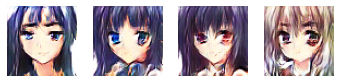

In [11]:
generate_faces()